In [ ]:
# Uninstall current versions
!pip uninstall -y tensorflow keras

# Install specific versions
!pip install tensorflow==2.15.0 keras==2.15.0

# Restart runtime
import os
os.kill(os.getpid(), 9)

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, BatchNormalization, Layer, Multiply, Reshape, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from scipy.ndimage import gaussian_filter, map_coordinates
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l2

# Paths to the dataset
base_path = '/content/drive/My Drive/LIMUC/train_and_validation_sets'
test_path = '/content/drive/My Drive/LIMUC/test_set'

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Define class names
class_names = ['Mayo 0', 'Mayo 1', 'Mayo 2', 'Mayo 3']
num_classes = len(class_names)



# Elastic deformation function with fixed random state
def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(42)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode='constant', cval=0) * alpha
    dz = np.zeros_like(dx)
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(image.shape)

# Set batch size
batch_size = 16

# Data generators for training and testing with advanced data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: elastic_transform(x, alpha=34, sigma=4),
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(380, 380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(380, 380),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Define the custom loss function
def ordinal_categorical_crossentropy_loss(y_true, y_pred, num_classes):
    epsilon = 1e-7  # Small constant for numerical stability
    lambda_penalty = 0.5
    beta = 0.3
    threshold = 0.5

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Adding epsilon to avoid log(0) or division by zero issues
    ce_loss = tf.keras.backend.categorical_crossentropy(y_true, y_pred + epsilon)

    prob_true_class = tf.reduce_sum(y_true * y_pred, axis=-1)
    threshold_penalty = lambda_penalty * tf.cast(tf.less(prob_true_class, threshold), tf.float32)

    true_classes = tf.argmax(y_true, axis=-1)
    predicted_classes = tf.argmax(y_pred, axis=-1)
    distance_penalty = beta * tf.abs(tf.cast(true_classes, tf.float32) - tf.cast(predicted_classes, tf.float32))

    loss = ce_loss + threshold_penalty + distance_penalty
    return tf.reduce_mean(loss)

# Define the Squeeze-and-Excitation Layer
class SqueezeExcitationLayer(Layer):
    def __init__(self, output_dim, ratio=16):
        super(SqueezeExcitationLayer, self).__init__()
        self.global_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(output_dim // ratio, activation='swish')
        self.dense2 = Dense(output_dim, activation='sigmoid')
        self.reshape = Reshape((1, 1, output_dim))
        self.multiply = Multiply()

    def call(self, inputs):
        x = self.global_pool(inputs)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.multiply([inputs, x])

# Define the Spatial Attention Layer
class SpatialAttentionLayer(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttentionLayer, self).__init__()
        self.conv1 = Conv2D(1, kernel_size, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        return self.conv1(concat) * inputs

# Custom loss function wrapper
def custom_loss(num_classes):
    def loss(y_true, y_pred):
        return ordinal_categorical_crossentropy_loss(y_true, y_pred, num_classes)
    return loss

# Build EfficientNet Model with Fine-Tuning and Attention Mechanism
def build_efficientnet_model(num_classes):
    base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))
    for layer in base_model.layers:
        layer.trainable = True

    inputs = Input(shape=(380, 380, 3))
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = SqueezeExcitationLayer(base_model.output_shape[-1])(x)
    x = SpatialAttentionLayer()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Use the custom loss function
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=custom_loss(num_classes), metrics=['accuracy'])
    return model



# Create arrays of file paths and labels
filepaths = np.array([train_generator.filepaths[i] for i in range(len(train_generator.filepaths))])
labels = np.array([train_generator.labels[i] for i in range(len(train_generator.labels))])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Convert integer labels to class names
def labels_to_class_names(labels):
    return [class_names[label] for label in labels]

# Function to create data generators for train and validation splits
def create_generators(train_files, train_labels, val_files, val_labels, batch_size=16):
    train_labels = labels_to_class_names(train_labels)
    val_labels = labels_to_class_names(val_labels)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(380, 380),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(380, 380),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

# Adaptive Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.5
    elif epoch < 15:
        return lr * 0.1
    else:
        return lr * 0.01

lr_callback = LearningRateScheduler(lr_scheduler)

# Prepare to store results for each fold
accuracy_results = []
kappa_results = []
mae_results = []
precision_results = []
recall_results = []
f1_results = []

# Save stratified k-fold splits
folds = list(skf.split(filepaths, labels))

Mounted at /content/drive
Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.


# 7th fold

106/106 [==============================] - 13s 118ms/step
Fold 7 Top-1 Accuracy: 0.8055
Fold 7 Top-2 Accuracy: 0.9852
Fold 7 Quadratic Weighted Kappa: 0.8812
Fold 7 Mean Absolute Error: 0.1969
Fold 7 Precision: 0.7523
Fold 7 Recall: 0.7496
Fold 7 F1 Score: 0.7508


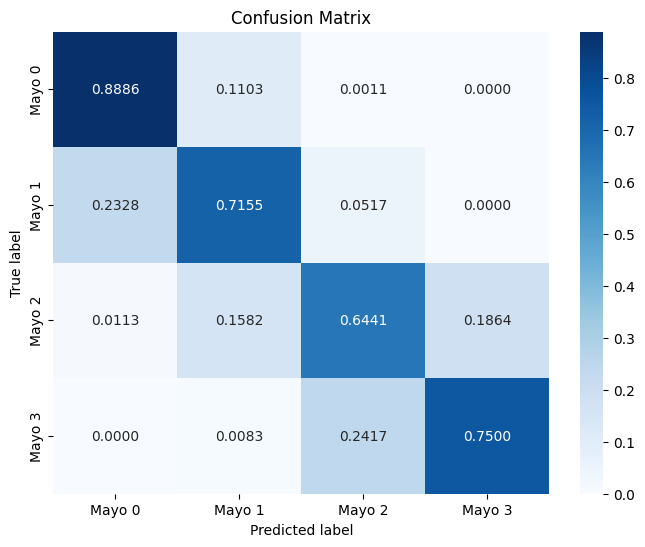

In [ ]:
# Get indices for the 7th fold
train_index, val_index = folds[6]

train_files = filepaths[train_index]
train_labels = labels[train_index]
val_files = filepaths[val_index]
val_labels = labels[val_index]

# Create data generators for the first fold
train_generator, val_generator = create_generators(train_files, train_labels, val_files, val_labels)

print("Fold 7")
print(f"Training: {len(train_files)} images")
print(f"Validation: {len(val_files)} images")

model = build_efficientnet_model(num_classes)

checkpoint = ModelCheckpoint('/content/drive/My Drive/LIMUC/Temp/RBSLF_best_model_fold_7.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, lr_callback, reduce_lr]
)

# Load the best weights and evaluate the model on the test set
model.load_weights('/content/drive/My Drive/LIMUC/Temp/RBSLF_best_model_fold_7.h5')

test_generator.reset()
test_preds = model.predict(test_generator)
test_y_true = test_generator.classes

# Calculate Top-1 Accuracy
test_y_pred_top1 = np.argmax(test_preds, axis=1)
fold_top1_accuracy = accuracy_score(test_y_true, test_y_pred_top1)

# Calculate Top-2 Accuracy
top2_pred = np.argsort(test_preds, axis=1)[:, -2:]
fold_top2_accuracy = np.mean([test_y_true[i] in top2_pred[i] for i in range(len(test_y_true))])

# Calculate QWK
fold_kappa = cohen_kappa_score(test_y_true, test_y_pred_top1, weights='quadratic')

fold_mae = mean_absolute_error(test_y_true, test_y_pred_top1)
fold_precision = precision_score(test_y_true, test_y_pred_top1, average='macro')
fold_recall = recall_score(test_y_true, test_y_pred_top1, average='macro')
fold_f1 = f1_score(test_y_true, test_y_pred_top1, average='macro')

accuracy_results.append(fold_top1_accuracy)
kappa_results.append(fold_kappa)
mae_results.append(fold_mae)
precision_results.append(fold_precision)
recall_results.append(fold_recall)
f1_results.append(fold_f1)

print(f"Fold 7 Top-1 Accuracy: {fold_top1_accuracy:.4f}")
print(f"Fold 7 Top-2 Accuracy: {fold_top2_accuracy:.4f}")
print(f"Fold 7 Quadratic Weighted Kappa: {fold_kappa:.4f}")
print(f"Fold 7 Mean Absolute Error: {fold_mae:.4f}")
print(f"Fold 7 Precision: {fold_precision:.4f}")
print(f"Fold 7 Recall: {fold_recall:.4f}")
print(f"Fold 7 F1 Score: {fold_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_y_true, test_y_pred_top1)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".4f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm_percentage, class_names, title='Confusion Matrix')
